<a href="https://colab.research.google.com/github/steinruck/data603-sp22/blob/project-submission/project/topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing in Spark: A Harry Potter Text Analysis
------------------

<img width=40% src="https://drive.google.com/uc?id=1OzWzINEE4ircGGW-BMWffUJo_NaNmUt3" align="left">

## Table of Contents

__[1. Introduction](#first-bullet)__

__[2. SparkNLP](#second-bullet)__

__[3.Preprocessing and Word Counts](#third-bullet)__

__[4. Character Analysis](#fourth-bullet)__

__[5. Topic Modeling](#fifth-bullet)__

__[6. Conclusion](#sixth-bullet)__

------------------

## 1. Introduction <a name="first-bullet"></a>
<img width=40% src="https://drive.google.com/uc?id=1KuVM2ADL1VLBnCJxVm94psK25jjIfq5y" align = "right">
Over a period of 10 years the entire Harry Potter series consisting of 7 books and over 1 million words was created. It contains over 80 spells, 700 characters, and has a series of overlapping plot devices and topics that effectively captured the attention of several generations. As a kid my dad gave me my first Harry Potter book when I was in the first grade and I was hooked. After that we went to evey midnight book release and movie premiere. Each member of my family would get their own copy of the book and we'd stay up all night reading it. We'd even get to skip school the next day if it was a school day. As such a large part of my childhood, it seemed fitting to use new skills to discover another dimension of the series.


### Project Goals
I already know a lot about Harry Potter. Throughout this project I want to extract hidden information and see how it fits in with my overall understanding of the series. Analysis activities will include:
- Document Assembly
- Sentence Detection
- Tokenization
- Stop Word Removal
- Preprocessing
- Word Count
    - total per book
    - most common words and their counts
- Character Analysis 
    - focus on Harry, Ron, Hermione, Dumbledore, and Voldemort
    - count occurances by book
    - count appearance of any two in the same sentance (simulate relationship)

### Data Source
This data comes in the form of 7 .txt files from a GitHub repo: https://github.com/formcept/whiteboard/tree/master/nbviewer/notebooks/data/harrypotter. I own 5 complete sets of the books myself, I just didn't have them in .txt format. I do not promote piracy or copyright infringement. Use of this data is for educational purposes only. The text was formatted and merged in a different notebook located in the same directory as this one and exported to a CSV called books_6_rows.csv. There are 7 rows but I don't feel like changing the name. That is the file that is used for this notebook.

### Getting Started
- This notebook was crafted and run in Google Colab. If you would like to run from a local host, follow the environment setup instructions from John Snow Labs for SparkNLP. It's extensive and confusing so I would not recommend. If you do manage to secure all the dependencies, simply change all file paths to reference your local machine.

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# this is to get sparknlp running in colab
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2022-05-12 11:25:16--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2022-05-12 11:25:16--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2022-05-12 11:25:16--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:44

In [3]:
# spark nlp imports
import sparknlp
from sparknlp import DocumentAssembler
from sparknlp.annotator import SentenceDetector
from sparknlp.annotator import Tokenizer
from pyspark.ml import Pipeline

# general pyspark imports
from pyspark.sql.functions import col, regexp_replace, concat_ws, split, collect_list, explode, size, expr, array_contains, udf
from pyspark.ml.feature import StopWordsRemover, CountVectorizer, IDF
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.clustering import LDA

In [4]:
# start sparknlp session
spark = sparknlp.start()

print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 3.4.4
Apache Spark version: 3.0.3


In [5]:
# load dataset
# starts as 7 rows; one for each book
data = spark.read.csv('/content/drive/Shareddrives/Project/submission/books_6_rows.csv', header='true')
data.show()

+--------------------+--------------------+
|                text|              titles|
+--------------------+--------------------+
| the boy who live...|The Philosophers ...|
| . . l harry pott...|The Chamber of Se...|
| owl post harry p...|The Prisoner of A...|
| the riddle house...|  The Goblet of Fire|
|harry potter dudl...|The Order of the ...|
| the other minist...|The Half-Blood Pr...|
|i the dark lord a...| The Deathly Hallows|
+--------------------+--------------------+



You can see above there are only 7 observations in this dataset; one for each book in the series. There are also some formatting errors, as well as extra characters. There are two columns, one containing titles, one containing the text. Both have string data types. 


In [6]:
# there are only two columns, both strings
print("There are " + str(data.count()) + " rows in this dataset")

data.printSchema()

There are 7 rows in this dataset
root
 |-- text: string (nullable = true)
 |-- titles: string (nullable = true)




## 2. SparkNLP <a name="second-bullet"></a>
This library from John Snow Labs includes many conventional Natural Language Processing options as well as a great number of pretrained models for a variety of purposes. If everything had gone to plan, I would have used pretrained models for lemmatization, named entity recognition, and others. However, running any pretrained model in Colab caused it to run out of ram, and any attempts to get a working environment using Databricks and a local Spark installation led to dependency issues I couldn't resolve. Instead, I will conduct some pre-processing and data cleaning using spark before moving into pandas and sklearn for modeling and prediction. 

</br>

---

</br>

### Formatting

The first step is to make sure the data is in the format needed for annotators to use. In `sparknlp`, annotators can be either estimators or transformers, similar to Spark ML. There are two types of annotators: AnnotatorApproach and AnnotatorModel. AnnotatorApproach methods require a `transform()`, and AnnotatorModel methods require a `fit()` and a `transform()`.

#### DocumentAssembler
>Transformers are used to convert a dataframe from one annotator type to the other. DocumentAssembler is one of these. This transformer annotates the raw data so that it is in the right format for other annotators to use. 

#### SentenceDetector
>The newly created 'document' column is fed into the SentenceDetector which creates an array of sentences and a new column called 'sentences'. In this case, the array is exploded so each sentence becomes a new line. 

#### Tokenizer
>Tokenizer is an annotator that transforms the DataFrame without using a pretrained model. It is used to convert strings into arrays of sentences with identifying metadata. It is of the AnnotatorModel type. 

#### Pipeline
> Spark NLP interacts with Spark ML via an API. All Spark annotators and transformers can be used in a pipeline. Each of the above can be run in sequence, passing the output as input to the next. 

In [7]:
# use DocumentAssembler on dataframe, input is the text column, output is document
# id is the title of the book so each sentence remains connected to the book
document_assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('document')\
    .setIdCol('titles')

# use SentenceDetector on document column, output sentence column - recognizes sentences
# explode set to true (makes each sentence its own line)
sent_detector = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentences')\
    .setExplodeSentences(True)

# use Tokenizer for word tokenization
tokenizer = Tokenizer()\
    .setInputCols(['sentences'])\
    .setOutputCol('tokens')

# set the stages of the pipeline
pipeline = Pipeline(stages=[
    document_assembler,
    sent_detector,
    tokenizer                         
])

# fit and transform 
pipeline_model = pipeline.fit(data).transform(data)

In [8]:
# the output of the pipeline is a dataframe. It doesn't provide much use at first glance
pipeline_model.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|              titles|            document|           sentences|              tokens|
+--------------------+--------------------+--------------------+--------------------+--------------------+
| the boy who live...|The Philosophers ...|[[document, 0, 41...|[[document, 1, 13...|[[token, 1, 3, th...|
| the boy who live...|The Philosophers ...|[[document, 0, 41...|[[document, 139, ...|[[token, 139, 142...|
| the boy who live...|The Philosophers ...|[[document, 0, 41...|[[document, 273, ...|[[token, 273, 274...|
| the boy who live...|The Philosophers ...|[[document, 0, 41...|[[document, 346, ...|[[token, 346, 347...|
| the boy who live...|The Philosophers ...|[[document, 0, 41...|[[document, 430, ...|[[token, 430, 432...|
| the boy who live...|The Philosophers ...|[[document, 0, 41...|[[document, 620, ...|[[token, 620, 622...|
| the boy who live...|The Philosopher

In [9]:
# data can be extracted, such as the first sentence of the first document and its metadata
pipeline_model.first()['sentences'][0].asDict()

{'annotatorType': 'document',
 'begin': 1,
 'embeddings': [],
 'end': 137,
 'metadata': {'sentence': '0'},
 'result': 'the boy who lived mr. and mrs. dursley of number four privet drive were proud to say that they were perfectly normal thank you very much.'}

In [10]:
# the schema of the original dataframe has changed
# there are now 5 columns, with document, sentences, and tokens being arrays created in the pipeline
pipeline_model.printSchema()

root
 |-- text: string (nullable = true)
 |-- titles: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentences: array (nullable = false)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |--

In [11]:
# get a count of the new dataframe created by the pipeline
# this number is the same as the number of sentences in the entire series
pipeline_model.count()

84981

This is where I would use a pretrained model like `DistilBertEmbeddings()`, `NerDLModel.pretrained()`, to do some Named Entity recognition, or to do lemmatization. Since I couldn't get compute resources to cooperate, I will instead use Spark and Spark ML to do some further analysis. 

---

## 3. Preprocessing and Word Counts <a name="third-bullet"></a>
Though I couldn't continue with SparkNLP, I can use pieces of the results from the pipeline to continue with analysis using various aspects of Spark/Pyspark. Specifically, I am creating a new dataframe that pulls the results of the different annotator into their own columns without including the metadata.

In [12]:
# create a dataframe containing the title, sentence, and words
df = pipeline_model.withColumn('sentence', pipeline_model.sentences['result'])
df = df.withColumn('words', df.tokens['result'])

df = df.select(df['titles'], df['sentence'], df['words'])
df.show()

+--------------------+--------------------+--------------------+
|              titles|            sentence|               words|
+--------------------+--------------------+--------------------+
|The Philosophers ...|[the boy who live...|[the, boy, who, l...|
|The Philosophers ...|[they were the la...|[they, were, the,...|
|The Philosophers ...|[mr. dursley was ...|[mr, ., dursley, ...|
|The Philosophers ...|[he was big beefy...|[he, was, big, be...|
|The Philosophers ...|[mrs. dursley was...|[mrs, ., dursley,...|
|The Philosophers ...|[the dursley had ...|[the, dursley, ha...|
|The Philosophers ...|[the dursleys had...|[the, dursleys, h...|
|The Philosophers ...|[they didn think ...|[they, didn, thin...|
|The Philosophers ...|[mrs. potter was ...|[mrs, ., potter, ...|
|The Philosophers ...|[the dursleys shu...|[the, dursleys, s...|
|The Philosophers ...|[the dursleys kne...|[the, dursleys, k...|
|The Philosophers ...|[this boy was ano...|[this, boy, was, ...|
|The Philosophers ...|[wh

In [13]:
# count number of sentences per book
sent_count = df.withColumn('book', col('titles'))\
    .groupBy('book')\
    .count()\
    .sort('count')

sent_count.show(truncate=False)

+------------------------+-----+
|book                    |count|
+------------------------+-----+
|The Philosophers Stone  |6022 |
|The Chamber of Secrets  |6610 |
|The Prisoner of Azkaban |9663 |
|The Half-Blood Prince   |13039|
|The Deathly Hallows     |13794|
|The Goblet of Fire      |16532|
|The Order of the Phoenix|19321|
+------------------------+-----+



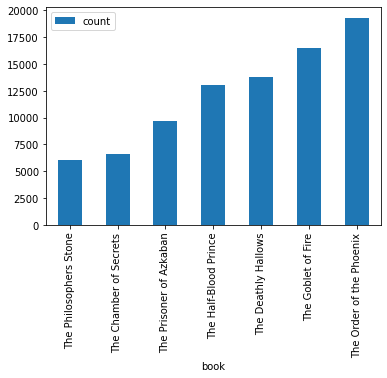

In [14]:
sent_count = sent_count.toPandas()
sent_count.plot.bar(x='book', y='count')

The Order of the Phoenix has the most sentences at 19320, The Philosopher's Stone has the fewest at 6023. This is a little innacurate because I don't know what extra stuff might be in the .txt files I used as my data. 

---
</br>

### Stop Word Removal
Analyzing text data and word importance is easier if you filter out common words known as stop words. There are many lists of stop words I could have used, but I went with one that removes the most just to see what's left over. The list was retrieved from: https://www.ranks.nl/stopwords 

In [15]:
# create stop word list (a few things were added on the end to try to clean up a bit more)
stop_words = ['a', 'able', 'about', 'above', 'abst', 'accordance', 'according', 'accordingly', 'across', 
              'act', 'actually', 'added', 'adj', 'affected', 'affecting', 'affects', 'after', 'afterwards', 
              'again', 'against', 'ah', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 
              'always', 'am', 'among', 'amongst', 'an', 'and', 'announce', 'another', 'any', 'anybody', 
              'anyhow', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apparently', 
              'approximately', 'are', 'aren', 'arent', 'arise', 'around', 'as', 'aside', 'ask', 'asking', 
              'at', 'auth', 'available', 'away', 'awfully', 'b', 'back', 'be', 'became', 'because', 'become', 
              'becomes', 'becoming', 'been', 'before', 'beforehand', 'begin', 'beginning', 'beginnings', 
              'begins', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'between', 'beyond', 
              'biol', 'both', 'brief', 'briefly', 'but', 'by', 'c', 'ca', 'came', 'can', 'cannot', "can't", 
              'cause', 'causes', 'certain', 'certainly', 'co', 'com', 'come', 'comes', 'contain', 'containing', 
              'contains', 'could', 'couldnt', 'd', 'date', 'did', "didn't", 'different', 'do', 'does', "doesn't", 
              'doing', 'done', "don't", 'down', 'downwards', 'due', 'during', 'e', 'each', 'ed', 'edu', 'effect', 
              'eg', 'eight', 'eighty', 'either', 'else', 'elsewhere', 'end', 'ending', 'enough', 'especially', 
              'et', 'et-al', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 
              'ex', 'except', 'f', 'far', 'few', 'ff', 'fifth', 'first', 'five', 'fix', 'followed', 'following', 
              'follows', 'for', 'former', 'formerly', 'forth', 'found', 'four', 'from', 'further', 'furthermore', 
              'g', 'gave', 'get', 'gets', 'getting', 'give', 'given', 'gives', 'giving', 'go', 'goes', 'gone', 
              'got', 'gotten', 'h', 'had', 'happens', 'hardly', 'has', "hasn't", 'have', "haven't", 'having', 
              'he', 'hed', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'heres', 'hereupon', 'hers', 
              'herself', 'hes', 'hi', 'hid', 'him', 'himself', 'his', 'hither', 'home', 'how', 'howbeit', 'however', 
              'hundred', 'i', 'id', 'ie', 'if', "i'll", 'im', 'immediate', 'immediately', 'importance', 'important', 
              'in', 'inc', 'indeed', 'index', 'information', 'instead', 'into', 'invention', 'inward', 'is', "isn't", 
              'it', 'itd', "it'll", 'its', 'itself', "i've", 'j', 'just', 'k', 'keep', 'keeps', 'kept', 'kg', 'km', 
              'know', 'known', 'knows', 'l', 'largely', 'last', 'lately', 'later', 'latter', 'latterly', 'least', 
              'less', 'lest', 'let', 'lets', 'like', 'liked', 'likely', 'line', 'little', "'ll", 'look', 'looking', 
              'looks', 'ltd', 'm', 'made', 'mainly', 'make', 'makes', 'many', 'may', 'maybe', 'me', 'mean', 'means', 
              'meantime', 'meanwhile', 'merely', 'mg', 'might', 'million', 'miss', 'ml', 'more', 'moreover', 'most', 
              'mostly', 'mr', 'mrs', 'much', 'mug', 'must', 'my', 'myself', 'n', 'na', 'name', 'namely', 'nay', 'nd', 
              'near', 'nearly', 'necessarily', 'necessary', 'need', 'needs', 'neither', 'never', 'nevertheless', 
              'new', 'next', 'nine', 'ninety', 'no', 'nobody', 'non', 'none', 'nonetheless', 'noone', 'nor', 
              'normally', 'nos', 'not', 'noted', 'nothing', 'now', 'nowhere', 'o', 'obtain', 'obtained', 'obviously', 
              'of', 'off', 'often', 'oh', 'ok', 'okay', 'old', 'omitted', 'on', 'once', 'one', 'ones', 'only', 'onto', 
              'or', 'ord', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 
              'over', 'overall', 'owing', 'own', 'p', 'page', 'pages', 'part', 'particular', 'particularly', 'past', 
              'per', 'perhaps', 'placed', 'please', 'plus', 'poorly', 'possible', 'possibly', 'potentially', 'pp', 
              'predominantly', 'present', 'previously', 'primarily', 'probably', 'promptly', 'proud', 'provides', 
              'put', 'q', 'que', 'quickly', 'quite', 'qv', 'r', 'ran', 'rather', 'rd', 're', 'readily', 'really', 
              'recent', 'recently', 'ref', 'refs', 'regarding', 'regardless', 'regards', 'related', 'relatively', 
              'research', 'respectively', 'resulted', 'resulting', 'results', 'right', 'run', 's', 'said', 'same', 
              'saw', 'say', 'saying', 'says', 'sec', 'section', 'see', 'seeing', 'seem', 'seemed', 'seeming', 
              'seems', 'seen', 'self', 'selves', 'sent', 'seven', 'several', 'shall', 'she', 'shed', "she'll", 
              'shes', 'should', "shouldn't", 'show', 'showed', 'shown', 'showns', 'shows', 'significant', 
              'significantly', 'similar', 'similarly', 'since', 'six', 'slightly', 'so', 'some', 'somebody', 
              'somehow', 'someone', 'somethan', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 
              'soon', 'sorry', 'specifically', 'specified', 'specify', 'specifying', 'still', 'stop', 'strongly', 
              'sub', 'substantially', 'successfully', 'such', 'sufficiently', 'suggest', 'sup', 'sure', 't', 
              'take', 'taken', 'taking', 'tell', 'tends', 'th', 'than', 'thank', 'thanks', 'thanx', 'that', 
              "that'll", 'thats', "that've", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 
              'there', 'thereafter', 'thereby', 'thered', 'therefore', 'therein', "there'll", 'thereof', 
              'therere', 'theres', 'thereto', 'thereupon', "there've", 'these', 'they', 'theyd', "they'll", 
              'theyre', "they've", 'think', 'this', 'those', 'thou', 'though', 'thoughh', 'thousand', 'throug', 
              'through', 'throughout', 'thru', 'thus', 'til', 'tip', 'to', 'together', 'too', 'took', 'toward', 
              'towards', 'tried', 'tries', 'truly', 'try', 'trying', 'ts', 'twice', 'two', 'u', 'un', 'under', 
              'unfortunately', 'unless', 'unlike', 'unlikely', 'until', 'unto', 'up', 'upon', 'ups', 'us', 'use', 
              'used', 'useful', 'usefully', 'usefulness', 'uses', 'using', 'usually', 'v', 'value', 'various', 
              "'ve", 'very', 'via', 'viz', 'vol', 'vols', 'vs', 'w', 'want', 'wants', 'was', 'wasnt', 'way', 
              'we', 'wed', 'welcome', "we'll", 'went', 'were', 'werent', "we've", 'what', 'whatever', "what'll", 
              'whats', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 
              'wheres', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whim', 'whither', 'who', 'whod', 
              'whoever', 'whole', "who'll", 'whom', 'whomever', 'whos', 'whose', 'why', 'widely', 'willing', 
              'wish', 'with', 'within', 'without', 'wont', 'words', 'world', 'would', 'wouldnt', 'www', 'x', 
              'y', 'yes', 'yet', 'you', 'youd', "you'll", 'your', 'youre', 'yours', 'yourself', 'yourselves', 
              "you've", 'z', 'zero', 'rowling', 've', 'll', '', ' ', '.']

In [16]:
# create the stop word remover, using 'words' as input, and 'no_stop' as output column.
# Set the newly created stop_word list as the stopWords
remover = StopWordsRemover(inputCol='words', outputCol='no_stop', stopWords=stop_words)

# run the remover transformer on the entire dataframe
no_stop = remover.transform(df)

# pring first 20
no_stop.show()

+--------------------+--------------------+--------------------+--------------------+
|              titles|            sentence|               words|             no_stop|
+--------------------+--------------------+--------------------+--------------------+
|The Philosophers ...|[the boy who live...|[the, boy, who, l...|[boy, lived, durs...|
|The Philosophers ...|[they were the la...|[they, were, the,...|[people, expect, ...|
|The Philosophers ...|[mr. dursley was ...|[mr, ., dursley, ...|[dursley, directo...|
|The Philosophers ...|[he was big beefy...|[he, was, big, be...|[big, beefy, man,...|
|The Philosophers ...|[mrs. dursley was...|[mrs, ., dursley,...|[dursley, thin, b...|
|The Philosophers ...|[the dursley had ...|[the, dursley, ha...|[dursley, small, ...|
|The Philosophers ...|[the dursleys had...|[the, dursleys, h...|[dursleys, wanted...|
|The Philosophers ...|[they didn think ...|[they, didn, thin...|[didn, bear, pott...|
|The Philosophers ...|[mrs. potter was ...|[mrs, ., po

I'm sure there's a better way, but since I'm using the output of sparknlp I can't just change one and have the rest be fine. I want to remove the rest of the punctuation and single letters from the dataset, so I am going to join the 'no_stop' column, remove punctuation and single letters, and then split again. 

In [17]:
# make each row a single string instead of list
no_stop = no_stop.withColumn("clean", concat_ws(",", "no_stop"))

# remove special characters
no_stop = no_stop.withColumn('clean', regexp_replace(no_stop['clean'], "[^0-9a-zA-Z]+", ' '))

# remove single letters
no_stop = no_stop.withColumn('clean', regexp_replace(no_stop['clean'], "\s+[a-zA-Z]\s+", ' '))

# delete extra spaces
no_stop = no_stop.withColumn('clean', regexp_replace(no_stop['clean'],"\s+", ' ' ))

# split sentences back to words on space
no_stop = no_stop.withColumn('clean', split(col("clean")," "))

no_stop.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|              titles|            sentence|               words|             no_stop|               clean|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|The Philosophers ...|[the boy who live...|[the, boy, who, l...|[boy, lived, durs...|[boy, lived, durs...|
|The Philosophers ...|[they were the la...|[they, were, the,...|[people, expect, ...|[people, expect, ...|
|The Philosophers ...|[mr. dursley was ...|[mr, ., dursley, ...|[dursley, directo...|[dursley, directo...|
|The Philosophers ...|[he was big beefy...|[he, was, big, be...|[big, beefy, man,...|[big, beefy, man,...|
|The Philosophers ...|[mrs. dursley was...|[mrs, ., dursley,...|[dursley, thin, b...|[dursley, thin, b...|
|The Philosophers ...|[the dursley had ...|[the, dursley, ha...|[dursley, small, ...|[dursley, small, ...|
|The Philosophers ...|[the dursleys h

In [18]:
print(no_stop.first()['clean'])

['boy', 'lived', 'dursley', 'number', 'privet', 'drive', 'perfectly', 'normal']


### Word Counts
From here I would like to get some more counts about various aspects of each book. To do this, I need to group by book. I am going to create one for total word count including stop words, and one without stop words to compare.

In [19]:
# take no_stop dataframe, split each word from cleaned column into own row
books = no_stop.withColumn('words', explode('clean'))

# group words by title and put words in a list in a column called 'words'
books = books.groupBy('titles').agg(collect_list('words').alias('words'))
books.show()

+--------------------+--------------------+
|              titles|               words|
+--------------------+--------------------+
|  The Goblet of Fire|[riddle, house, v...|
|The Half-Blood Pr...|[minister, nearin...|
|The Order of the ...|[harry, potter, d...|
|The Philosophers ...|[boy, lived, durs...|
|The Prisoner of A...|[owl, post, harry...|
|The Chamber of Se...|[, , harry, potte...|
| The Deathly Hallows|[dark, lord, asce...|
+--------------------+--------------------+



In [20]:
# same as above but use the 'words' column (pre stop word removal)
books_s = no_stop.withColumn('words', explode('words'))
books_s = books_s.groupBy('titles').agg(collect_list('words').alias('words'))
books_s.show()

+--------------------+--------------------+
|              titles|               words|
+--------------------+--------------------+
|  The Goblet of Fire|[the, riddle, hou...|
|The Half-Blood Pr...|[the, other, mini...|
|The Order of the ...|[harry, potter, d...|
|The Philosophers ...|[the, boy, who, l...|
|The Prisoner of A...|[owl, post, harry...|
|The Chamber of Se...|[., ., l, harry, ...|
| The Deathly Hallows|[i, the, dark, lo...|
+--------------------+--------------------+



In [21]:
# get count of words in each book after stop word removal
books = books.withColumn('word_count', size('words'))
books.show()

+--------------------+--------------------+----------+
|              titles|               words|word_count|
+--------------------+--------------------+----------+
|  The Goblet of Fire|[riddle, house, v...|     85716|
|The Half-Blood Pr...|[minister, nearin...|     71465|
|The Order of the ...|[harry, potter, d...|    109780|
|The Philosophers ...|[boy, lived, durs...|     32143|
|The Prisoner of A...|[owl, post, harry...|     48115|
|The Chamber of Se...|[, , harry, potte...|     37556|
| The Deathly Hallows|[dark, lord, asce...|     83120|
+--------------------+--------------------+----------+



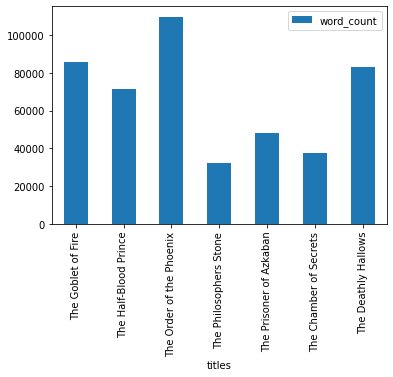

In [22]:
# convert to pandas, plot word counts after stop word removal
word_count = books.toPandas()
word_count.plot.bar(x='titles', y='word_count')

In [23]:
# get count of words in each book before stop word removal
books_s = books_s.withColumn('word_count', size('words'))
books_s.show()

+--------------------+--------------------+----------+
|              titles|               words|word_count|
+--------------------+--------------------+----------+
|  The Goblet of Fire|[the, riddle, hou...|    208689|
|The Half-Blood Pr...|[the, other, mini...|    178354|
|The Order of the ...|[harry, potter, d...|    271834|
|The Philosophers ...|[the, boy, who, l...|     81808|
|The Prisoner of A...|[owl, post, harry...|    114701|
|The Chamber of Se...|[., ., l, harry, ...|     90242|
| The Deathly Hallows|[i, the, dark, lo...|    208408|
+--------------------+--------------------+----------+



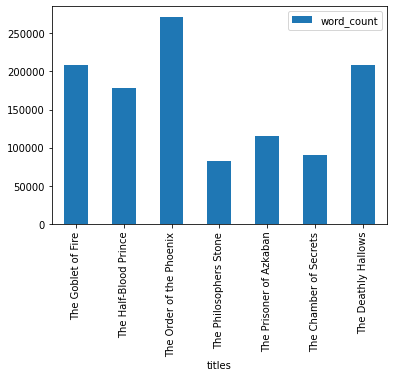

In [24]:
# convert to pandas, plot count before stop word removal
no_stop_count = books_s.toPandas()
no_stop_count.plot.bar(x='titles', y='word_count')

Before removing stop words and single letters (even though there still appear to be some in there), there are almost 150k more words in The Order of the Phoenix than without. There are about 43k more words in the Philosoper's Stone before removing stop words. These counts are of unique words. 

----

</br>

### Counts by Word
By book counts are helpful, but to get an idea of most common words, I needed to explode the data back out to one word per row. This way we can see the most common words per book and how often they occured.

In [25]:
# create new dataframe that explodes the 'words' column into a new column called 'word'
# group by title, then word, and get a count of occurances of that word in each book
# sort highest to lowest
unique_words = books.withColumn('word', explode(col('words')))\
    .groupBy('titles', 'word')\
    .count()\
    .sort('count', ascending=False)

In [26]:
# filter out blank words (not nulls)
unique_words = unique_words.filter(unique_words.word != '')
unique_words.show(50)

+--------------------+----------+-----+
|              titles|      word|count|
+--------------------+----------+-----+
|The Order of the ...|     harry| 4092|
|  The Goblet of Fire|     harry| 3598|
| The Deathly Hallows|     harry| 3193|
|The Half-Blood Pr...|     harry| 2789|
|The Prisoner of A...|     harry| 2049|
|The Chamber of Se...|     harry| 1658|
|The Philosophers ...|     harry| 1325|
|The Order of the ...|  hermione| 1307|
|The Order of the ...|       ron| 1307|
| The Deathly Hallows|  hermione| 1224|
| The Deathly Hallows|       ron| 1176|
|  The Goblet of Fire|       ron| 1043|
|The Half-Blood Pr...|dumbledore| 1034|
|The Half-Blood Pr...|       ron|  877|
|  The Goblet of Fire|  hermione|  871|
|The Prisoner of A...|       ron|  791|
|The Chamber of Se...|       ron|  706|
|The Half-Blood Pr...|  hermione|  694|
|The Prisoner of A...|  hermione|  672|
|  The Goblet of Fire|    potter|  664|
|The Order of the ...|      well|  664|
|The Order of the ...|dumbledore|  661|


These are the most common words in the entire series grouped by book, then word, and then sorted on count. There are still some empty strings in there even after all the processing, so I filtered those out. Overall, some of the most common words are harry, ron, hermione, dumbledore, professor, and hagrid. I could go back to the stop words removal and remove some that might seem relevant, or get counts if I remove all names and see what's left. Here we see the highest word counts first, so the shorter books don't make an appearance in this list unless I want to display more than 50 rows. 

---

## 4. Character Analysis <a name="fourth-bullet"></a>
I wanted to know some more about how often some characters appear in each book, and how often they occur in the same sentences. Since attempting to get information on every character would be time consuming and not terribly helpful, I chose to focus on 5: Harry, Ron, Hermione, Dumbledore, and Voldemort

In [27]:
# get a complete list of counts for each of the 5 characters, sorted by book and then count
characters = unique_words.filter((unique_words.word == 'harry') | (unique_words.word == 'ron') | (unique_words.word == 'hermione') | (unique_words.word == 'dumbledore') | (unique_words.word == 'voldemort'))\
    .sort('titles', 'count')
characters.show(35)

+--------------------+----------+-----+
|              titles|      word|count|
+--------------------+----------+-----+
|The Chamber of Se...| voldemort|   25|
|The Chamber of Se...|dumbledore|  159|
|The Chamber of Se...|  hermione|  320|
|The Chamber of Se...|       ron|  706|
|The Chamber of Se...|     harry| 1658|
| The Deathly Hallows| voldemort|  446|
| The Deathly Hallows|dumbledore|  589|
| The Deathly Hallows|       ron| 1176|
| The Deathly Hallows|  hermione| 1224|
| The Deathly Hallows|     harry| 3193|
|  The Goblet of Fire| voldemort|  237|
|  The Goblet of Fire|dumbledore|  599|
|  The Goblet of Fire|  hermione|  871|
|  The Goblet of Fire|       ron| 1043|
|  The Goblet of Fire|     harry| 3598|
|The Half-Blood Pr...| voldemort|  244|
|The Half-Blood Pr...|  hermione|  694|
|The Half-Blood Pr...|       ron|  877|
|The Half-Blood Pr...|dumbledore| 1034|
|The Half-Blood Pr...|     harry| 2789|
|The Order of the ...| voldemort|  211|
|The Order of the ...|dumbledore|  661|


I specified 5 main characters and counted how many times their names popped up during each book. 
- As expected, Harry is mentioned the most out of each book. 
- Despite his importance, Voldemort's name is mentioned the least. This in part is probably since most characters do not refer to him by name, and in the final book, no one can say his name without facing consequences. There is still a pretty large increase in mentions over the course of the series, starting at 38 and finishing at 446. 
- Dumbledore is mentioned the second least in all books except The Half Blood Prince, where he is second most. This makes sense, since that is the book where he and Harry have the most interaction. 
- Hermione and Ron are pretty even, with Ron coming out slightly ahead in most books. There is a tie in The Order of the Phoenix, and Hermionioe has more mentions in The Goblet of Fire and The Deathly Hallows. This is probably because Ron doesn't speak to Harry for a good portion of those books. 

In [28]:
# count number of times harry and ron appear in same sentence
print(" Harry and Ron appear in the same sentence " + str(no_stop.filter(array_contains(no_stop.clean, "harry") & array_contains(no_stop.clean, "ron")).count()) + " times")
print(" Harry and Hermione appear in the same sentence " + str(no_stop.filter(array_contains(no_stop.clean, "harry") & array_contains(no_stop.clean, "hermione")).count()) + " times")
print(" Hermione and Ron appear in the same sentence " + str(no_stop.filter(array_contains(no_stop.clean, "ron") & array_contains(no_stop.clean, "hermione")).count()) + " times")
print(" Harry and Dumbledore appear in the same sentence " + str(no_stop.filter(array_contains(no_stop.clean, "harry") & array_contains(no_stop.clean, "dumbledore")).count()) + " times")
print(" Harry and Voldemort appear in the same sentence " + str(no_stop.filter(array_contains(no_stop.clean, "harry") & array_contains(no_stop.clean, "voldemort")).count()) + " times")
print(" Ron and Dumbledore appear in the same sentence " + str(no_stop.filter(array_contains(no_stop.clean, "ron") & array_contains(no_stop.clean, "dumbledore")).count()) + " times")
print(" Hermione and Dumbledore appear in the same sentence " + str(no_stop.filter(array_contains(no_stop.clean, "hermione") & array_contains(no_stop.clean, "dumbledore")).count()) + " times")
print(" Dumbledore and Voldemort appear in the same sentence " + str(no_stop.filter(array_contains(no_stop.clean, "dumbledore") & array_contains(no_stop.clean, "voldemort")).count()) + " times")
print(" Voldemort and Ron appear in the same sentence " + str(no_stop.filter(array_contains(no_stop.clean, "ron") & array_contains(no_stop.clean, "voldemort")).count()) + " times")
print(" Hermione and Voldemort appear in the same sentence " + str(no_stop.filter(array_contains(no_stop.clean, "hermione") & array_contains(no_stop.clean, "voldemort")).count()) + " times")

 Harry and Ron appear in the same sentence 2207 times
 Harry and Hermione appear in the same sentence 1889 times
 Hermione and Ron appear in the same sentence 1645 times
 Harry and Dumbledore appear in the same sentence 956 times
 Harry and Voldemort appear in the same sentence 355 times
 Ron and Dumbledore appear in the same sentence 128 times
 Hermione and Dumbledore appear in the same sentence 126 times
 Dumbledore and Voldemort appear in the same sentence 112 times
 Voldemort and Ron appear in the same sentence 44 times
 Hermione and Voldemort appear in the same sentence 43 times


As a rudimentary method of relationship analysis I counted the occurances of each of Harry, Ron, Hermione, Dumbledore, and Voldemort in a sentance with one other character. In order of strongest to weakest character relationship:
- Harry and Ron
- Harry and Hermione
- Ron and Hermione
- Harry and Dumbledore
- Harry and Voldemort
- Ron and Dumbledore
- Hermione and Dumbledore
- Ron and Voldemort
- Hermione and Voldemort

---
 
</br>

## 5. Topic Modeling <a name="fifth-bullet"></a>
Since I couldn't use SparkNLP to do named entity recognition, I decided to use TF-IDF to determine important words and do some topic modeling. I started by calculating the frequency of each term in a document with CountVectorizer.

In [29]:
# the next few cells are from https://medium.com/trustyou-engineering/topic-modelling-with-pyspark-and-spark-nlp-a99d063f1a6e
tfizer = CountVectorizer(inputCol='words',
                         outputCol='tf_features')
tf_model = tfizer.fit(books)
tf_result = tf_model.transform(books)

Get the IDF (inverse frequency of documents where a term occurred)

In [30]:
idfizer = IDF(inputCol='tf_features', 
              outputCol='tf_idf_features')
idf_model = idfizer.fit(tf_result)
tfidf_result = idf_model.transform(tf_result)

Use LDA to identify the predefined number of topics within the data

In [31]:
num_topics = 35
max_iter = 100
lda = LDA(k=num_topics, 
          maxIter=max_iter, 
          featuresCol='tf_idf_features')
lda_model = lda.fit(tfidf_result)

View the words that describe the topicsusing a UDF that converts word ids (the actual output for a topic by a topic model) into words:

In [32]:
vocab = tf_model.vocabulary
def get_words(token_list):
    return [vocab[token_id] for token_id in token_list]
udf_to_words = udf(get_words, ArrayType(StringType()))

View words for each modelled topic using describeTopics(). Show 10

In [33]:
num_top_words = 10
topics = lda_model\
     .describeTopics(num_top_words)\
     .withColumn('topicWords', udf_to_words(col('termIndices')))
topics.select('topic', 'topicWords').show(truncate=False)

+-----+---------------------------------------------------------------------------------------------------------+
|topic|topicWords                                                                                               |
+-----+---------------------------------------------------------------------------------------------------------+
|0    |[misty, aids, dimmer, needin, centaur, paralyze, greatest, edgily, infuriated, pointedly]                |
|1    |[bugs, intents, dabbling, fibs, issue, whoosh, hops, spanning, oddballs, draughts]                       |
|2    |[wiped, invite, refuge, blazing, gobletful, wail, examination, mistrustful, mundanely, kidnapped]        |
|3    |[lupin, pettigrew, marge, dementors, scabbers, boggart, trelawney, buckbeak, firebolt, crookshanks]      |
|4    |[furry, reproduce, saucers, eagle, reentered, presses, translucent, referee, bes, pensive]               |
|5    |[slughorn, mclaggen, morfin, merope, horcrux, felix, hokey, felicis, demelza, rom

Some of the topics are very vague, and there are a lot of words shared between them. Many of them seem like just a list of names. It might be beneficial to perform LDA individually on each book for separate topic lists, and to remove common names to see how that changes the output. 

## 6. Conclusion <a name="sixth-bullet"></a>
Despite being unable to get SparkNLP to fully work without running out of RAM, I was still able to use it for some of the breakdown and preparation of the text. I am hoping that I can get a working environment in the future so I can play with some of the pretrained models to see how they hold up against books that I know so well. I didn't end up getting to the part of my project where I was going to move out of spark and create a neural network for text generation, but I'm working on it and hope to be done next week! Overall my Harry Potter knowledge and understanding was confirmed, including most common words, longest books, character interactions, etc. I would like to keep playing with the topic modeling part to see if I can increase the usefulness of the topics, specifically to generate by book topics. I just couldn't feasably do that right now since it takes an unfortunate amount of time to run this entire notebooks. 